# Basics of Pandas
Pandas is a great tool for manipulating tabular data in Python, which makes it a great way to learn basic functions for working with datasets.

We'll create an example where we compare the experimental and computed bandgaps for different materials.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

Data locations. We are going to use [experiment](https://foundry-ml.org/#/datasets/10.18126%2Fwg3u-g8vu) and [computational](https://foundry-ml.org/#/datasets/10.18126%2F7io9-1z9k) datasets hosted by the [Foundry project](https://foundry-ml.org/#/).

In [2]:
exp_url = 'https://data.materialsdatafacility.org/foundry/foundry_experimental_band_gaps_v1.1/data_exp_no_repeat_new.json'
dft_url = 'https://data.materialsdatafacility.org/foundry/foundry_assorted_computational_band_gaps_v1.1/All_no_MP_Aflow_OQMD_new.json'

## Reading
Pandas [can read from numerous tabular data formats](https://pandas.pydata.org/docs/user_guide/io.html). All are all named `read_X` and can download data from the internet for you.

In [3]:
exp_data = pd.read_json(exp_url, lines=True)
print(f'Loaded {len(exp_data)} records')

Loaded 2808 records


It's that easy. We now have a tabular dataset with a few thousand records and more data than we'll need, such as the full structure.

In [4]:
exp_data.head()

,reference,icsd_id,structure,composition,comments,bandgap type,exp method,bandgap value (eV),space group,temp (K)
0,41,MPDS-S1531436,"{'@module': 'pymatgen.core.structure', '@class...",Ge0.9Si0.08C0.02,MPDS database,,O,1.05,Fd-3m,
1,1,238499,"{'@module': 'pymatgen.core.structure', '@class...",CsSc(SeO3)2,UV-vis diffuse reflectance spectroscopy,,O,5.2,Pnma,300
2,1,416461,"{'@module': 'pymatgen.core.structure', '@class...",EuLiH3,Optical,,O,1.5,Pm-3m,
3,1,262893,"{'@module': 'pymatgen.core.structure', '@class...",Ba2InErSe5,UV-vis-NIR diffuse reflectance spectroscopy,,O,2.29,Cmc2_1,
4,1,50460,"{'@module': 'pymatgen.core.structure', '@class...",Cs2AgVS4,Optical,,O,1.77,Fddd,


You can delete columns and from the dataset pretty easily.

In [5]:
exp_data.drop(columns=['structure'], inplace=True)  # Inplace alters the variable. Pandas returns a new copy by default, leaving the original intact
exp_data.head()

,reference,icsd_id,composition,comments,bandgap type,exp method,bandgap value (eV),space group,temp (K)
0,41,MPDS-S1531436,Ge0.9Si0.08C0.02,MPDS database,,O,1.05,Fd-3m,
1,1,238499,CsSc(SeO3)2,UV-vis diffuse reflectance spectroscopy,,O,5.2,Pnma,300
2,1,416461,EuLiH3,Optical,,O,1.5,Pm-3m,
3,1,262893,Ba2InErSe5,UV-vis-NIR diffuse reflectance spectroscopy,,O,2.29,Cmc2_1,
4,1,50460,Cs2AgVS4,Optical,,O,1.77,Fddd,


## Cleaning the data
The dataset is a little messy. Some of the columns have lists for bandgap values rather than single values and those single values are strings and not floats, which complicate analysis but yield an teaching moment for the benefits of Pandas.

Let's show how to remove them and process the data into useful values

In [6]:
try:
    exp_data['bandgap value (eV)'].max()
except TypeError as e:
    print(e)

'>=' not supported between instances of 'str' and 'list'


Pandas has a [built-in function for converting strings to numbers](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html)

In [7]:
pd.to_numeric(exp_data['bandgap value (eV)'], errors='coerce')

0       1.05
1       5.20
2       1.50
3       2.29
4       1.77
        ... 
2803    1.48
2804    0.47
2805     NaN
2806    4.20
2807    3.88
Name: bandgap value (eV), Length: 2808, dtype: float64

It returns a list of floats, which is exactly what we need. So, let's store that value as the new column because we don't need the old one

In [8]:
exp_data['bandgap value (eV)'] = pd.to_numeric(exp_data['bandgap value (eV)'], errors='coerce')

You may have noticed some of th evalues are not numbers (`NaN`s). We can use Pandas's selection tools for removing them.

One route is to supply a list of booleans.

In [9]:
exp_data['bandgap value (eV)'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
2803    False
2804    False
2805     True
2806    False
2807    False
Name: bandgap value (eV), Length: 2808, dtype: bool

In [10]:
exp_data = exp_data[~exp_data['bandgap value (eV)'].isnull()]
print(f'Reduced to {len(exp_data)} values')

Reduced to 2069 values


You can also query. For example, to get the only the bandgaps which we know to be direct.

In [11]:
exp_data.query('`bandgap type`=="D"')  # `` are used because the column name has spaces

,reference,icsd_id,composition,comments,bandgap type,exp method,bandgap value (eV),space group,temp (K)
6,3,172174,Cu2O,Semiconductor Data Handbook,D,O,2.17,Pn-3mZ,0
37,3,165226,Bi2Se3,Semiconductor Data Handbook,D,O,0.16,R-3mH,77
53,2,676090,ZnSe,Atomwork,D,O,2.66,F-43m,
56,2,676090,ZnSe,Atomwork,D,O,2.70,F-43m,280
68,3,8249,GaTe,Semiconductor Data Handbook,D,E,1.70,B112/m,300
...,...,...,...,...,...,...,...,...,...
2719,2,675398,AlN,Atomwork,D,O,3.56,Fm-3m,
2720,3,257810,AlN,Semiconductor Data Handbook,D,O,6.13,P63mc,300
2739,3,40018,Se,Semiconductor Data Handbook,D,O,1.95,P3121,300
2756,3,86361,GeAs,Semiconductor Data Handbook,D,O,1.01,C12/m1,300


The full query syntax supports all kind of complex expressions

## Aggregating
Many common data analysis require running the same class of analysis on different subsets of the data, "aggregation" operations are key for this. 

There are many [aggregation operations in Pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html). Simple ones like getting descriptive statistics

In [12]:
exp_data['bandgap value (eV)'].mean()

2.37224770420493

In [13]:
exp_data['bandgap value (eV)'].agg(['mean', 'count', 'sem', 'std'])

mean        2.372248
count    2069.000000
sem         0.042796
std         1.946634
Name: bandgap value (eV), dtype: float64

In [14]:
exp_data['bandgap value (eV)'].describe()

count    2069.000000
mean        2.372248
std         1.946634
min         0.000000
25%         1.100000
50%         2.000000
75%         3.000000
max        15.114000
Name: bandgap value (eV), dtype: float64

Or complicated ones like counting numbers of occurances

In [15]:
exp_data['composition'].value_counts()

InSe                     17
SiC                      16
GaAs                      9
AlAs                      9
GaSe                      9
                         ..
CuInS2                    1
Tl0.5Pr0.075In0.425Te     1
ZnIn2S4                   1
BaSn2F5Br                 1
Na3Sn2F6Cl                1
Name: composition, Length: 1443, dtype: int64

They can also be performed on specific groups of data. Form groups by using the "group by" operation, 

In [16]:
exp_data.groupby('composition')['bandgap value (eV)'].agg(['mean', 'max', 'std', 'sem'])

,mean,max,std,sem
composition,,,,
Ag0.25Zn0.5Ga0.25Se,1.63000,1.63,NaN,NaN
Ag0.5Cu0.5InSe2,1.10000,1.10,NaN,NaN
Ag2CdGeS4,2.32000,2.32,NaN,NaN
Ag2O,1.44275,1.60,0.184328,0.092164
Ag2PdO2,0.18000,0.18,NaN,NaN
...,...,...,...,...
Zr3O,0.20000,0.20,NaN,NaN
ZrO2,2.50000,4.99,2.241740,1.120870
ZrS2,0.85000,0.85,NaN,NaN


Grouping can even take multiple tags and be chained together with query operations

> Chaining is why `inplace=False` is a useful default in Pandas

In [17]:
exp_data.query('`bandgap type` != "D"').groupby(['composition', 'space group'])['bandgap value (eV)'].mean()

composition      space group
Ag0.5Cu0.5InSe2  I-42d          1.100000
Ag2CdGeS4        Pna2_1         2.320000
Ag2O             Imma           1.523667
Ag2PdO2          Immm           0.180000
Ag2S             Fm-3m          0.870000
                                  ...   
ZrO2             Fm-3m          2.066667
                 P121/c1        3.800000
ZrS2             Fm-3m          0.850000
ZrSe2            R-3m           2.000000
ZrSe3            R-3m           1.250000
Name: bandgap value (eV), Length: 1481, dtype: float64

Let's end by making a single dataset with the average bandgap for each composition and spacegroup

In [18]:
exp_bandgaps = exp_data.groupby(['composition', 'space group'])['bandgap value (eV)'].mean().reset_index()  # reset turns the single-column series into a dataframe
exp_bandgaps

,composition,space group,bandgap value (eV)
0,Ag0.25Zn0.5Ga0.25Se,F-43m,1.630000
1,Ag0.5Cu0.5InSe2,I-42d,1.100000
2,Ag2CdGeS4,Pna2_1,2.320000
3,Ag2O,Imma,1.523667
4,Ag2O,Pn-3mZ,1.200000
...,...,...,...
1564,ZrO2,Fm-3m,2.066667
1565,ZrO2,P121/c1,3.800000
1566,ZrS2,Fm-3m,0.850000
1567,ZrSe2,R-3m,2.000000


We'll give you some exercises later to help you see the power of aggregation operations.

## Joining
Data analyses often require _joining_ two different sources of data together. We'll showcase this by analyzing the differences between experiment and computation.

In [19]:
dft_data = pd.read_json(dft_url, lines=True).drop(columns=['structure', 'icsd_id'])
dft_data.head()

,reference,composition,comments,bandgap type,comp method,bandgap value (eV),space group
0,134,Al2O3,PRB 270,I,GW,9.30,R-3c
1,134,Al2ZnS4,PRB 270,I,GW,3.99,Fd-3m
2,134,Al2ZnSe4,PRB 270,I,GW,3.77,I-4
3,134,AlAs,PRB 270,I,GW,2.59,P6_3mc
4,134,AlAs,PRB 270,I,GW,2.34,F-43m


In [20]:
dft_data['comp method'] = dft_data['comp method'].str.upper()

There are [many types of join operations](https://www.devart.com/dbforge/sql/sqlcomplete/sql-join-statements.html). [Prepare for Venn Diagrams](https://www.devart.com/dbforge/sql/sqlcomplete/sql-join-statements.html) if you want to learn more about them.

A common type are "inner joins" where you get the rows from different datasets with values that match

In [21]:
joined_data = dft_data.merge(exp_bandgaps, on=['composition', 'space group'], suffixes=('_dft', '_exp'))
joined_data.head()

,reference,composition,comments,bandgap type,comp method,bandgap value (eV)_dft,space group,bandgap value (eV)_exp
0,134,AlAs,PRB 270,I,GW,2.340000,F-43m,2.594222
1,134,AlAs,PRB 270,I,MBJ,2.180000,F-43m,2.594222
2,130,AlAs,CMR mp_gllbsc,D,GLLB_SC,3.151458,F-43m,2.594222
3,130,AlAs,CMR mp_gllbsc,I,GLLB_SC,2.653349,F-43m,2.594222
4,jarvis,AlAs,jarvis mbj bandgap,,MBJ,2.276300,F-43m,2.594222


Note how we know have band gap values for both experiment and each computational record

In [22]:
joined_data['error'] = joined_data['bandgap value (eV)_exp'] - joined_data['bandgap value (eV)_dft']

In [23]:
joined_data.groupby('comp method')['error'].describe()

,count,mean,std,min,25%,50%,75%,max
comp method,,,,,,,,
GLLB_SC,221.0,-0.522718,1.218616,-4.007231,-1.100251,-0.480954,0.214478,2.520721
GW,50.0,-0.249235,1.265640,-3.500000,-0.555000,-0.113750,0.407500,2.580000
GWVD,5.0,-0.748400,2.009169,-4.029000,-0.904000,-0.175000,-0.000333,1.366333
MBJ,293.0,0.171344,1.089989,-5.483400,-0.187033,0.161050,0.757100,3.086000
OPTB88,412.0,1.120867,1.087031,-3.260800,0.340050,1.037950,1.642975,5.150000


Plotting to make a visual display. Pandas does have [some plotting helpers](https://pandas.pydata.org/docs/user_guide/visualization.html)

In [24]:
num_methods = joined_data['comp method'].value_counts().size
print(f'Found {num_methods} computational methods')

Found 5 computational methods


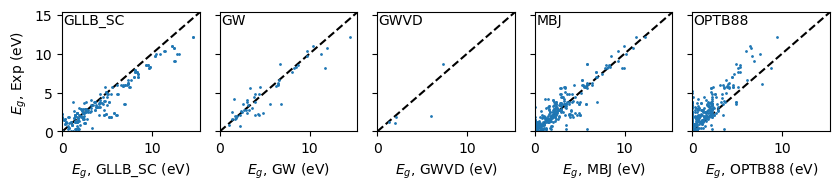

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(8.5, 2.), sharey=True, sharex=True)

for ax, (method, group) in zip(axs, joined_data.groupby('comp method')):
    ax.scatter(group['bandgap value (eV)_dft'], group['bandgap value (eV)_exp'], s=1)
    ax.text(0.01, 0.99, method, transform=ax.transAxes, ha='left', va='top')
    ax.set_xlabel(f'$E_g$, {method} (eV)')

# Get the range
max_eg = max(max(ax.get_xlim()) for ax in axs)
ax.set_xlim(0, max_eg)
ax.set_ylim(ax.get_xlim())

# Make a y=x line
for ax in axs:
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--', zorder=-1)
axs[0].set_ylabel('$E_g$, Exp (eV)')
    
fig.tight_layout()

Pandas makes it easy to manipulate data.

## Exercises
Here are a few questions which will test your ability to use Pandas. Try to do them in as few steps as possible.

_Add a column to `exp_data` which is the temperature in Celcius_.
<code hidden>exp_data['temp (C)'] = pd.to_numeric(exp_data['temp (K)'], errors='coerce') - 273.15</code>

_Which composition, space group, and method have the largest error?_
<code hidden>joined_data.loc[joined_data['error'].abs().idxmax(), ['composition', 'space group', 'comp method', 'error']]</code>

_How many compositions have experiment bandgaps at more than one temperature_?
<code hidden>(exp_data.groupby('composition')['temp (K)'].value_counts() > 1).sum()</code>

_What is the median error between each method and experiment?_
<code hidden>joined_data.groupby('comp method')['error'].median()</code>

_What is the mean absolute error after subtracting off this median error_? Hint: I used [apply](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.apply.html).
<code hidden>joined_data.groupby('comp method').apply(lambda x: (x['error'] - x['error'].median()).abs().mean())</code>

_Which are the compounds where 4 of 5 computational methods have been evaluated_?
<code hidden>joined_data.drop_duplicates(['composition', 'space group', 'comp method']).groupby(['composition', 'space group']).filter(lambda x: len(x) == 4)['composition'].value_counts()</code>